In [ ]:

!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-iody1ofa
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-iody1ofa
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9131ce0e5bc0c89904541bc0355d933ccd6acbfb
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import json
import cv2

train_images_path = '/content/drive/MyDrive/welding dataset/The Welding Defect Dataset/train/images'
train_labels_path = '/content/drive/MyDrive/welding dataset/The Welding Defect Dataset/train/labels'
val_images_path = '/content/drive/MyDrive/welding dataset/The Welding Defect Dataset/valid/images'
val_labels_path = '/content/drive/MyDrive/welding dataset/The Welding Defect Dataset/valid/labels'

category_names = ["crack", "porosity", "spatter"]


categories = [{"id": idx, "name": name} for idx, name in enumerate(category_names)]

def yolo_to_coco(images_path, labels_path):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": categories
    }
    annotation_id = 0

    for img_id, image_file in enumerate(sorted(os.listdir(images_path))):
        image_path = os.path.join(images_path, image_file)
        label_path = os.path.join(labels_path, image_file.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        coco_data["images"].append({
            "id": img_id,
            "width": width,
            "height": height,
            "file_name": image_path,
        })

        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, w, h = map(float, line.split())

                x_min = int((x_center - w / 2) * width)
                y_min = int((y_center - h / 2) * height)
                bbox_width = int(w * width)
                bbox_height = int(h * height)

                annotation = {
                    "id": annotation_id,
                    "image_id": img_id,
                    "category_id": int(class_id),
                    "bbox": [x_min, y_min, bbox_width, bbox_height],
                    "area": bbox_width * bbox_height,
                    "iscrowd": 0,
                }
                coco_data["annotations"].append(annotation)
                annotation_id += 1

    return coco_data


train_coco = yolo_to_coco(train_images_path, train_labels_path)
val_coco = yolo_to_coco(val_images_path, val_labels_path)

with open('/content/drive/MyDrive/welding_train.json', 'w') as f:
    json.dump(train_coco, f)
with open('/content/drive/MyDrive/welding_val.json', 'w') as f:
    json.dump(val_coco, f)


In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("welding_train", {}, "/content/drive/MyDrive/welding_train.json", train_images)
register_coco_instances("welding_val", {}, "/content/drive/MyDrive/welding_val.json", valid_images)


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("welding_train",)
cfg.DATASETS.TEST = ("welding_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(config['names'])

cfg.OUTPUT_DIR = "/content/drive/MyDrive/welding_defect_model_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


cfg.MODEL.DEVICE = "cpu"

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

evaluator = COCOEvaluator("welding_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "welding_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


[11/14 08:27:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


WARNING [11/14 08:27:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/14 08:27:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/14 08:27:47 d2.data.datasets.coco]: Loaded 176 images in COCO format from /content/drive/MyDrive/welding_val.json
[11/14 08:27:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/14 08:27:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/14 08:27:47 d2.data.common]: Serializing 176 elements to byte tensors and concatenating them all ...
[11/14 08:27:47 d2.data.common]: Serialized dataset takes 0.08 MiB
[11/14 08:27:47 d2.evaluation.evaluator]: Start inference on 176 batches
[11/14 08:27:52 d2.evaluation.ev

OrderedDict([('bbox',
              {'AP': 0.0033600743534909047,
               'AP50': 0.01490016307769292,
               'AP75': 0.00010924627715999007,
               'APs': 0.029152147688261465,
               'APm': 0.0021378382170684014,
               'APl': 0.15557701072315702,
               'AP-Bad Weld': 0.0,
               'AP-Good Weld': 0.0077842145256838274,
               'AP-Defect': 0.0022960085347888868})])

In [ ]:
import os
import torch
from detectron2.engine import DefaultTrainer


model = trainer.model

output_dir = '/content/drive/MyDrive/welding_defect_model_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

torch.save(model.state_dict(), os.path.join(output_dir, 'model_final.pth'))
print("Model saved as model_final.pth")


Model saved as model_final.pth


[11/14 08:45:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/welding_defect_model_output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

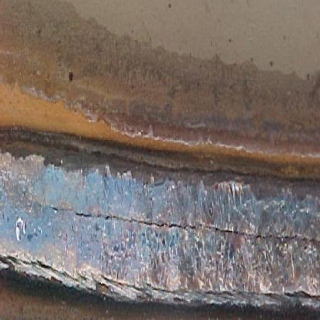

In [ ]:
!pip install opencv-python
import cv2

from detectron2.engine import DefaultPredictor
from google.colab.patches import cv2_imshow  # Import cv2_imshow

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/welding_defect_model_output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

image_path = '/content/drive/MyDrive/welding dataset/The Welding Defect Dataset/test/images/1aa4b44c-d01b8a11-Hot-crack_jpg.rf.57393ca7936f061ca5991481b2b5c485.jpg'
im = cv2.imread(image_path)
outputs = predictor(im)

from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1], scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/welding_defect_model_output/model_final.pth", "/content/drive/MyDrive/welding_defect_model.pth")


'/content/drive/MyDrive/welding_defect_model.pth'